In [1]:
import os, sys
import torch
import optuna.visualization as vis
from optuna.trial import TrialState
import pickle
from models.backbones import get_model
from utils.tune_utils import run_optuna_search
from utils.viz_utils import plot_training_metrics

In [2]:
sys.path = list(dict.fromkeys(sys.path))  # reset path first
# paths relative to project root
PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

In [4]:
model_list = ["resnet50", "vit_base", "dinov3"]

In [ ]:
# running optuna
all_studies = run_optuna_search(model_list, n_trials=15)

In [ ]:
# directories
CHECKPOINTS_DIR = "saves/checkpoints"
LOGS_DIR = "saves/logs" # if the saves directory is empty use instead the saves form the models/... path
DATA_DIR = "data/splits"

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


========== RESNET50 ==========
Pruned trials: 4
Completed trials: 11
Total trials: 15
Picked hyperparameters:
  lr: 0.0072210420727878005
  weight_decay: 0.0008639125997181148
  optimizer: SGD

Best model metrics and plots:
  Train Loss: 0.0266
  Train Acc : 99.1574
  Val Loss  : 0.0603
  Val Acc   : 98.1852
From trial: 10
At epoch: 10


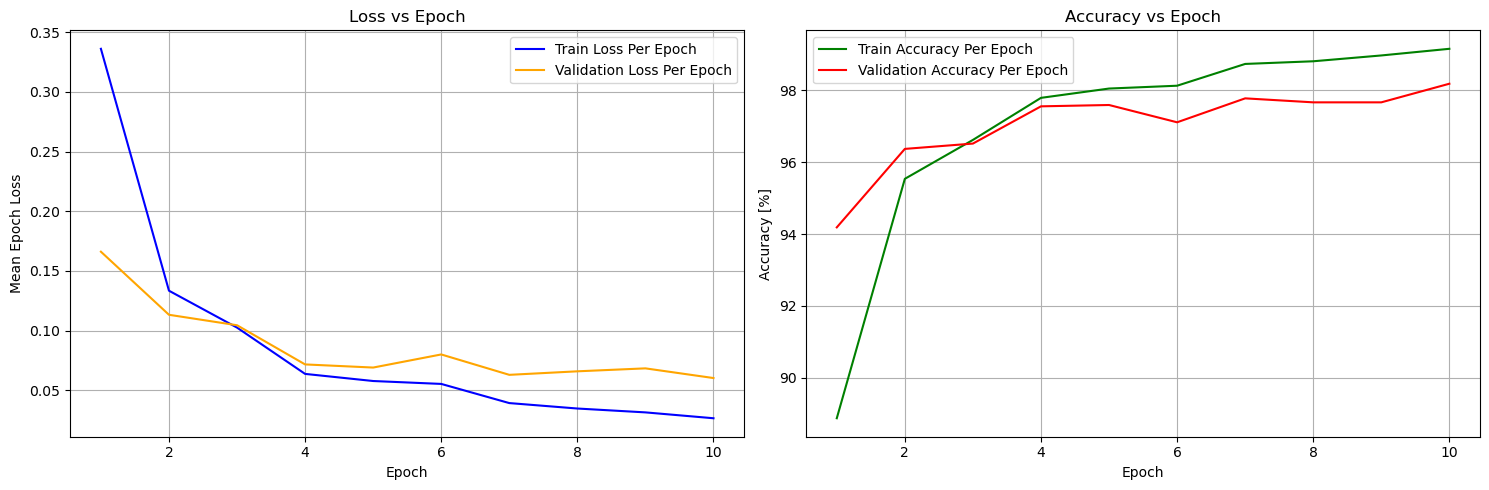


Optuna Visualizations:



========== VIT_BASE ==========
Pruned trials: 4
Completed trials: 11
Total trials: 15
Picked hyperparameters:
  lr: 7.86607378968825e-05
  weight_decay: 0.00014125402798267282
  optimizer: AdamW

Best model metrics and plots:
  Train Loss: 0.0107
  Train Acc : 99.6713
  Val Loss  : 0.0411
  Val Acc   : 98.7407
From trial: 14
At epoch: 10


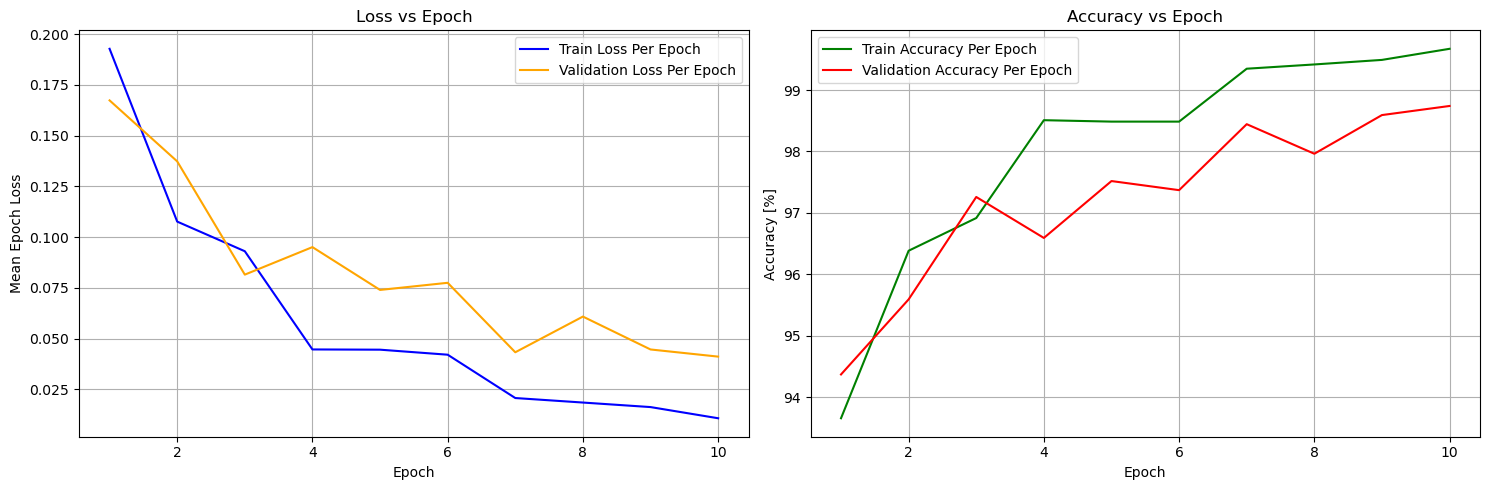


Optuna Visualizations:



========== DINOV3 ==========
Pruned trials: 6
Completed trials: 9
Total trials: 15
Picked hyperparameters:
  lr: 0.005599658232052883
  weight_decay: 2.155182423091798e-05
  optimizer: AdamW

Best model metrics and plots:
  Train Loss: 0.0714
  Train Acc : 97.6435
  Val Loss  : 0.1572
  Val Acc   : 95.7407
From trial: 10
At epoch: 27


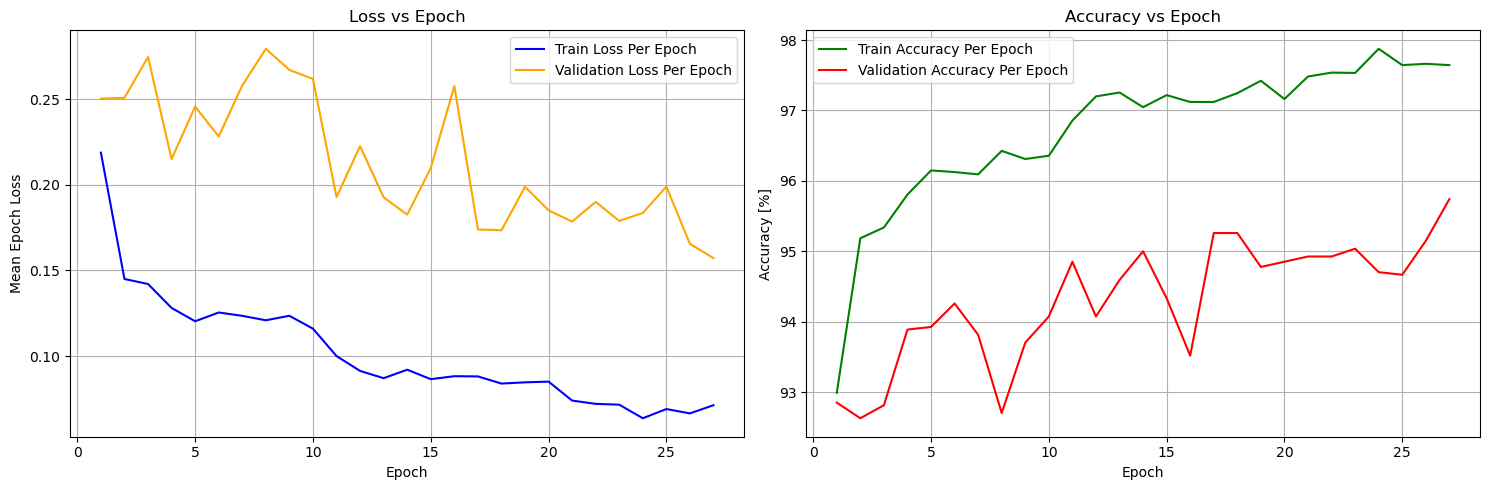


Optuna Visualizations:


In [9]:
# visualizations and plots
for model_name in model_list:
    print(f"\n========== {model_name.upper()} ==========")
    # loading the corresponding (best) model
    MODEL_CHECKPOINTS_DIR = os.path.join(CHECKPOINTS_DIR, f"BEST_{model_name}.pth")
    fine_tune = (model_name != "dinov3")
    model = get_model(model_name, num_classes=10, fine_tune=fine_tune).to(device)
    checkpoint = torch.load(MODEL_CHECKPOINTS_DIR, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    # loading the study
    study_path = os.path.join(LOGS_DIR, f"{model_name}_study.pkl")
    with open(study_path, "rb") as f:
        study = pickle.load(f)

    # the number of the completed and pruned trails
    pruned_trials = study.get_trials(states=[TrialState.PRUNED])
    complete_trials = study.get_trials(states=[TrialState.COMPLETE])

    print(f"Pruned trials: {len(pruned_trials)}")
    print(f"Completed trials: {len(complete_trials)}")
    print(f"Total trials: {len(study.trials)}")

    # best trial info
    best_trial = study.best_trial

    print("Picked hyperparameters:")
    for k, v in best_trial.params.items():
        print(f"  {k}: {v}")

    # loading metrics of best model
    metrics_path = os.path.join(LOGS_DIR, f"{model_name}_metrics.pt")
    metrics = torch.load(metrics_path, weights_only=True)


    final_train_loss = metrics["train_loss"][-1]
    final_train_acc = metrics["train_acc"][-1]
    final_val_loss = metrics["val_loss"][-1]
    final_val_acc = metrics["val_acc"][-1]

    print("\nBest model metrics and plots:")
    print(f"  Train Loss: {final_train_loss:.4f}")
    print(f"  Train Acc : {final_train_acc:.4f}")
    print(f"  Val Loss  : {final_val_loss:.4f}")
    print(f"  Val Acc   : {final_val_acc:.4f}")
    print("From trial:", checkpoint["trial"])
    print("At epoch:", checkpoint["epoch"]+1)
    plot_training_metrics(metrics["train_loss"], metrics["val_loss"],metrics["train_acc"], metrics["val_acc"])

    # optuna visualizations
    print("\nOptuna Visualizations:")
    vis.plot_optimization_history(study).show()
    vis.plot_param_importances(study).show()
    vis.plot_parallel_coordinate(study).show()
    vis.plot_contour(study, params=["lr", "weight_decay"]).show()
